In [1]:
#load scikit learn libraries for cross validation and model fit
import category_encoders as ce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import re
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
#load movie data
cleaned_movies = pd.read_csv("cleaned_movies.csv")

In [3]:
# transform the gross_earn to log
cleaned_movies['log_gross_earn'] = np.log(cleaned_movies['gross_earn'] + 1)

In [4]:
cleaned_movies.columns

Index(['poster', 'title', 'certificate', 'runtime', 'genre', 'rating', 'about',
       'director', 'stars', 'votes', 'gross_earn', 'director_avg_earn',
       'log_gross_earn'],
      dtype='object')

In [19]:
#split training and test data and y
X = cleaned_movies.drop(columns = ['log_gross_earn','stars','poster','title', 'certificate','gross_earn','director','about'])
y = cleaned_movies['log_gross_earn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train
X_test
y_train
y_test

1501    3.887935
2586    4.286754
2653    3.946424
1055    3.993787
705     4.618284
          ...   
4711    0.139762
2313    0.223144
3214    2.200552
2732    3.605770
1926    4.237290
Name: log_gross_earn, Length: 1000, dtype: float64

In [20]:
X

,runtime,genre,rating,votes,director_avg_earn
0,142.0,Drama,9.3,2626905.0,54.635000
1,152.0,"Action, Crime, Drama",9.0,2598173.0,201.832222
2,148.0,"Action, Adventure, Sci-Fi",8.8,2304062.0,201.832222
3,139.0,Drama,8.8,2071088.0,86.519000
4,154.0,"Crime, Drama",8.9,2011013.0,78.026250
...,...,...,...,...,...
4995,102.0,"Comedy, Drama, Musical",7.3,25112.0,10.563333
4996,94.0,"Comedy, Romance",5.9,28515.0,47.625520
4997,106.0,"Comedy, Drama, Romance",8.1,23957.0,47.625520
4998,92.0,"Comedy, Drama, Family",7.0,21536.0,5.750000


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer

# Define categorical and numerical feature columns
categorical_features = ['genre']
numerical_features = ['runtime', 'rating', 'votes', 'director_avg_earn']

# Define the preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])


In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNeighborsRegressor
param_grid = {
    'n_neighbors': [3, 5, 7],  # Experiment with different k values
    'metric': ['euclidean', 'manhattan'],  # Choose distance metric
    'weights': ['uniform', 'distance']  # Choose weighting scheme
}

# Create a pipeline with GridSearchCV for KNeighborsRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', GridSearchCV(KNeighborsRegressor(), param_grid=param_grid))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Get the best estimator from the pipeline
best_estimator = pipeline.named_steps['knn'].best_estimator_

# Get the best k value and other hyperparameters
best_k = best_estimator.n_neighbors  # View the chosen k
best_metric = best_estimator.metric
best_weights = best_estimator.weights

print("Best K:", best_k)
print("Best Metric:", best_metric)
print("Best Weights:", best_weights)

# Make predictions using the best hyperparameters
y_pred = pipeline.predict(X_test)

Best K: 7
Best Metric: manhattan
Best Weights: distance


In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Exponentiate the predicted and actual values to get them back to the original scale
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Calculate RMSE in the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RMSE (Original Scale): {rmse_original}")

RMSE (Original Scale): 36.15865667950502


In [26]:
from sklearn.metrics import r2_score, mean_absolute_error

# Exponentiate the predictions and actual values to the original scale
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

# Calculate R² score
r2 = r2_score(y_test_original, y_pred_original)
print(f"R² Score (Original Scale): {r2}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE (Original Scale): {mae}")

R² Score (Original Scale): 0.6089000304843739
MAE (Original Scale): 21.478211273841175


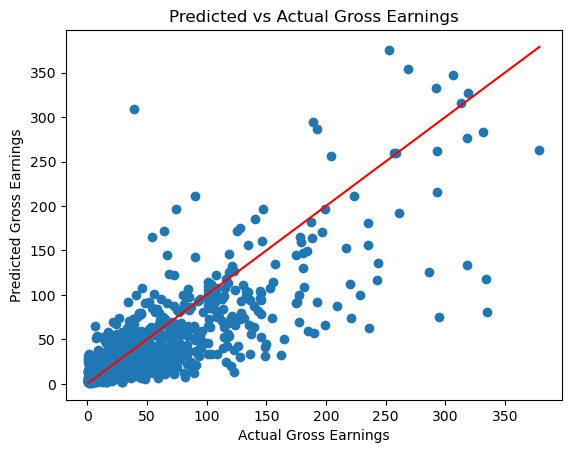

In [27]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted
plt.scatter(y_test_original, y_pred_original)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red')
plt.xlabel("Actual Gross Earnings")
plt.ylabel("Predicted Gross Earnings")
plt.title("Predicted vs Actual Gross Earnings")
plt.show()

Based on these observations of this scatterplot, we can conclude that the KNN model is not a perfect predictor of movie gross earnings. It has some limitations in accurately predicting the exact value. However, it does capture the general trend and provides a reasonable estimate in many cases.

The above KNN is an improvement from a previous KNN model we tried.  It seems to improve our model using one hot encoding for the categorical variables instead of using target encoding.  The KNN model is still not optimal in it's results so it will be helpful to try other models and see their predictive performance.